In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993224 sha256=c970a79c1169297f29c9637dc130eaaf5fd35e680208f2bcebc401c8ca01748a
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
pip install keras


In [ ]:
pip install tensorflow


In [ ]:
#import required libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
#from keras.preprocessing.sequence import pad_sequences
#from tensorflow.keras.preprocessing.sequence import pad_sequences
#from keras.models import Sequential
#from keras.layers import Embedding, LSTM, Dense
#from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from langdetect import detect
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/Datasets/yelp_academic_dataset_review.json'

In [ ]:
# Load a subset of the dataset (adjust chunk_size and num_samples)
chunk_size = 1000
num_samples = 50000

# Create an empty list to store DataFrames
dataframe = []

# Open the JSON file and process it in chunks with explicit encoding
with open(file_path, 'r', encoding='utf-8') as file:
    for chunk in pd.read_json(file, lines=True, chunksize=chunk_size):
        # Perform sentiment analysis on the 'text' column
        dataframe.append(chunk[['text', 'stars']].copy())
        if sum(map(len, dataframe)) >= num_samples:
            break

# Concatenate the list of DataFrames into the final DataFrame
yelp_subset = pd.concat(dataframe, ignore_index=True)

output_json_file_path = 'yelp_subset.json'
yelp_subset.to_json(output_json_file_path, orient='records', lines=True)

# Display the shape of the loaded subset
print("Shape of Yelp Subset:", yelp_subset.shape)

Shape of Yelp Subset: (50000, 2)


In [ ]:
yelp_subset.head()

,text,stars
0,"If you decide to eat here, just be aware it is...",3
1,I've taken a lot of spin classes over the year...,5
2,Family diner. Had the buffet. Eclectic assortm...,3
3,"Wow! Yummy, different, delicious. Our favo...",5
4,Cute interior and owner (?) gave us tour of up...,4


# Exploratory Data Analysis

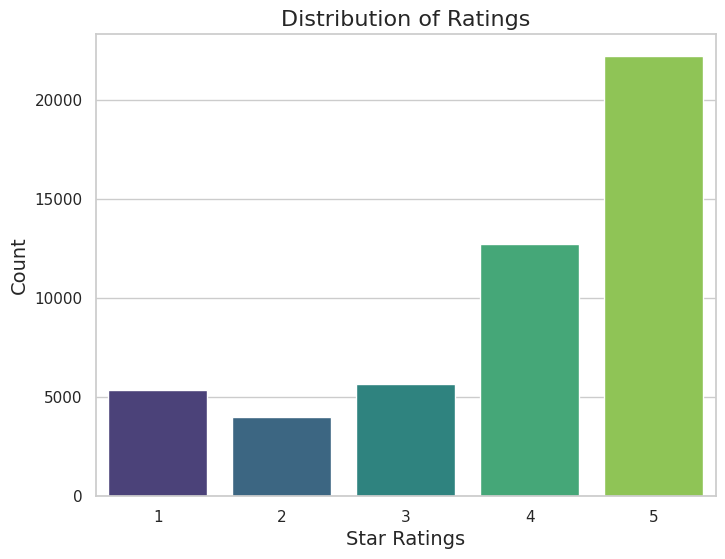

In [ ]:
# Set seaborn style
sns.set(style="whitegrid")

# 2. Distribution of Ratings
plt.figure(figsize=(8, 6))
sns.countplot(x='stars', data=yelp_subset, palette="viridis")
plt.title('Distribution of Ratings', fontsize=16)
plt.xlabel('Star Ratings', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

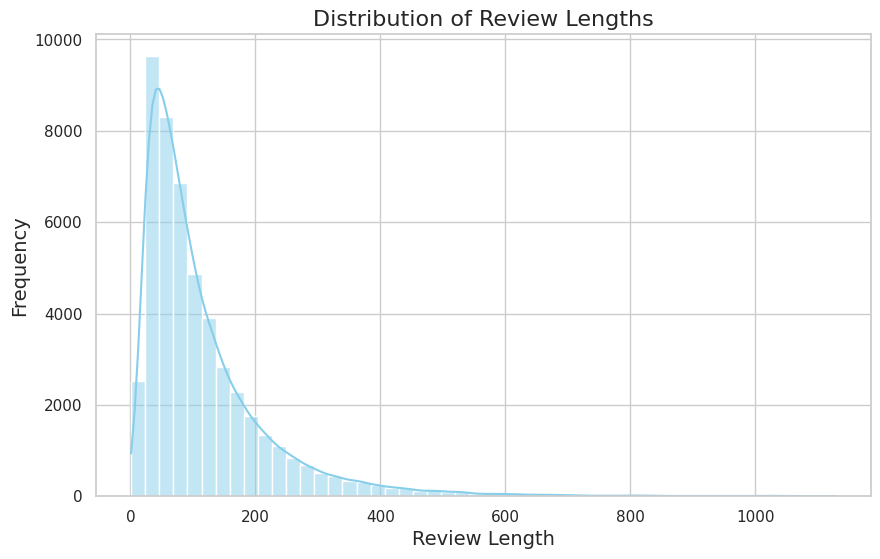

In [ ]:
#Review Length Distribution
plt.figure(figsize=(10, 6))
yelp_subset['review_length'] = yelp_subset['text'].apply(lambda x: len(word_tokenize(x)))
sns.histplot(yelp_subset['review_length'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Review Lengths', fontsize=16)
plt.xlabel('Review Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

In [ ]:
# insert a column to store language information
yelp_subset['language'] = yelp_subset['text'].apply(lambda x: detect(x) if isinstance(x, str) else None)

# calculate the  word counts for reviews in each language
yelp_subset['word_count'] = yelp_subset['text'].apply(lambda x: len(word_tokenize(x)) if isinstance(x, str) else 0)


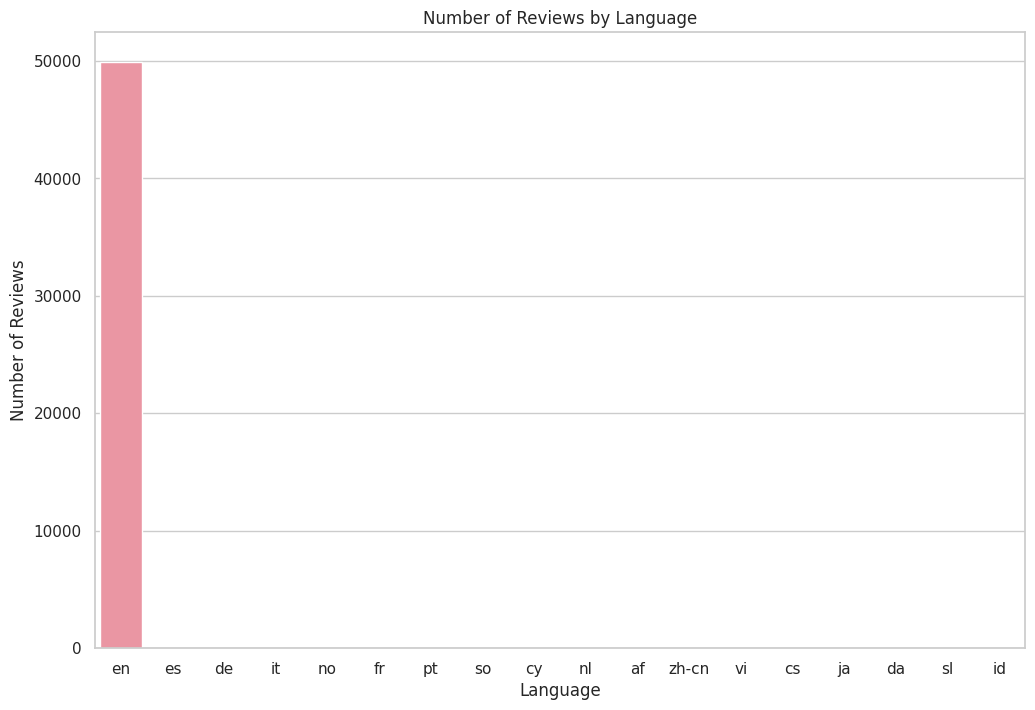

In [ ]:
#new column for number of reviews for each language
review_counts_by_language = yelp_subset['language'].value_counts().reset_index()

#plot for the number of reviews for each language to check if there are non-english words
plt.figure(figsize=(12, 8))
sns.barplot(x='index', y='language', data=review_counts_by_language)
plt.title('Number of Reviews by Language')
plt.xlabel('Language')
plt.ylabel('Number of Reviews')
plt.show()

# Preprocessing



### Feature Engineering

In [ ]:
#derive sentiment labels from star labels
yelp_subset['sentiment'] = yelp_subset['stars'].apply(lambda x: 'positive' if x > 3 else ('negative' if x < 3 else 'neutral'))

### Text Normalization

In [ ]:
#handle imbalane classes with random oversampling
x_train, x_test, y_train, y_test = train_test_split(yelp_subset['text'], yelp_subset['sentiment'], test_size=0.2, random_state=42)

In [ ]:
#convert all text to lowercase for uniformity
x_train = x_train.apply(lambda x: x.lower())
x_test = x_test.apply(lambda x: x.lower())

In [ ]:
#remove punctuation to reduce noise in the text.
x_train = x_train.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
x_test = x_test.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

In [ ]:
#remove common words that may not contribute much to sentiment
stop_words = set(stopwords.words('english'))
x_train = x_train.apply(lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in stop_words]))
x_test = x_test.apply(lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in stop_words]))

In [ ]:
#reduce words to the base form
lemmatizer = WordNetLemmatizer()
x_train = x_train.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))
x_test = x_test.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))

In [ ]:
#reshape x_train to have two dimensions
x_train_reshape = x_train.values.reshape(-1, 1)

#oversample the minority classes
over_sampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
x_train_over_resampled, y_train_resampled = over_sampler.fit_resample(x_train_reshape, y_train)

#convert oversampled indices to text sequences
x_train_over = x_train_over_resampled.flatten()

### Tokenization

In [ ]:
#maximum number of words to keep based on word frequency
max_num_words = 3000

#create a tokenizer
tokenizer = Tokenizer(num_words=max_num_words,#replace the  words not in the tokenizer's vocabulary
                       oov_token='<OOV>')

#fit the tokenizer on text
tokenizer.fit_on_texts(x_train_over)

#convert the text to integers sequences
x_train_seq = tokenizer.texts_to_sequences(x_train_over)
x_test_seq = tokenizer.texts_to_sequences(x_test)

#define maximum length of the sequence
max_len = 300

#pad sequences to make sentences to the same length
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len)
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len)


### Model Building

In [ ]:
#converting integer indices representing words into dense vectors of fixed size
embedding_dim = 50


model = Sequential()
model.add(Embedding(input_dim=max_num_words,#size of the vocabulary
                    output_dim=embedding_dim,#size of dense embeddings
                    input_length=max_len))#maximum length of input sequences
#model.add(LSTM(100, return_sequences=True))  # Additional LSTM layer
model.add(LSTM(100, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))#to handle overfitting
model.add(Dense(3, activation='softmax')) # 3 output nodes for positive, negative, and neutral

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

### Label Encoding

In [ ]:
#convert categorical sentiment labels ('positive','negative','neutral') into numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_resampled)
y_test_encoded = label_encoder.transform(y_test)

# Convert numerical lables to one-hot encoding
y_train_one_hot = pd.get_dummies(y_train_encoded)
y_test_one_hot = pd.get_dummies(y_test_encoded)

# Model Training

In [ ]:
#early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# model training
history = model.fit(
    x_train_pad,
    y_train_one_hot,
    epochs=60,
    batch_size=500,
    validation_split=0.1,
    callbacks=[early_stopping]  #add the early stopping callback
)


Epoch 1/60
151/151 [==============================] - 17s 99ms/step - loss: 1.1417 - accuracy: 0.5816 - val_loss: 1.4349 - val_accuracy: 0.0681
Epoch 2/60
151/151 [==============================] - 9s 58ms/step - loss: 0.6862 - accuracy: 0.7261 - val_loss: 0.9904 - val_accuracy: 0.5143
Epoch 3/60
151/151 [==============================] - 8s 53ms/step - loss: 0.5600 - accuracy: 0.7856 - val_loss: 0.8922 - val_accuracy: 0.6154
Epoch 4/60
151/151 [==============================] - 7s 49ms/step - loss: 0.4899 - accuracy: 0.8151 - val_loss: 0.8009 - val_accuracy: 0.6633
Epoch 5/60
151/151 [==============================] - 7s 45ms/step - loss: 0.4666 - accuracy: 0.8256 - val_loss: 0.6261 - val_accuracy: 0.7512
Epoch 6/60
151/151 [==============================] - 7s 44ms/step - loss: 0.4375 - accuracy: 0.8370 - val_loss: 0.6867 - val_accuracy: 0.7207
Epoch 7/60
151/151 [==============================] - 7s 46ms/step - loss: 0.4263 - accuracy: 0.8429 - val_loss: 0.6807 - val_accuracy: 0.730

# Model Evaluation

In [ ]:
#save the trained model
model.save('lstm_model_v3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#load the model
loaded_model = load_model('lstm_model_v3.h5')

In [ ]:
loss, accuracy = model.evaluate(x_test_pad, y_test_one_hot)#assess the performance on test data
print(f'Test Accuracy: {accuracy * 100:.2f}%')

313/313 [==============================] - 2s 7ms/step - loss: 0.5368 - accuracy: 0.7968
Test Accuracy: 79.68%


In [ ]:
#calculate predictions
y_pred = model.predict(x_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(np.array(y_test_one_hot), axis=1)

313/313 [==============================] - 2s 5ms/step


In [ ]:
# calculate precision, recall, and F1 score
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

In [ ]:
print(f'Precision: {precision}, Recall: {recall}, F1 Score: {f1}')

Precision: 0.8413736179679321, Recall: 0.7968, F1 Score: 0.8138722271967281


313/313 [==============================] - 2s 7ms/step


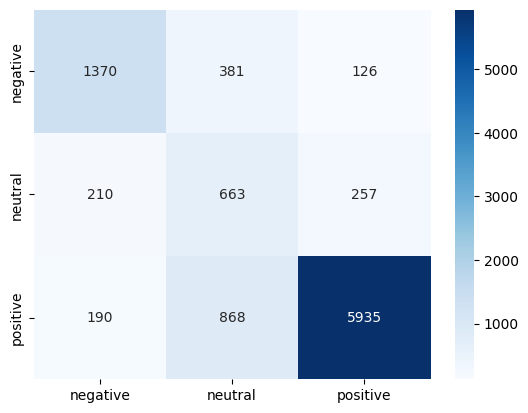

In [ ]:
y_pred = model.predict(x_test_pad)
y_pred_classes = np.argmax(y_pred, axis=-1)

cm = confusion_matrix(y_test_encoded, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.show()

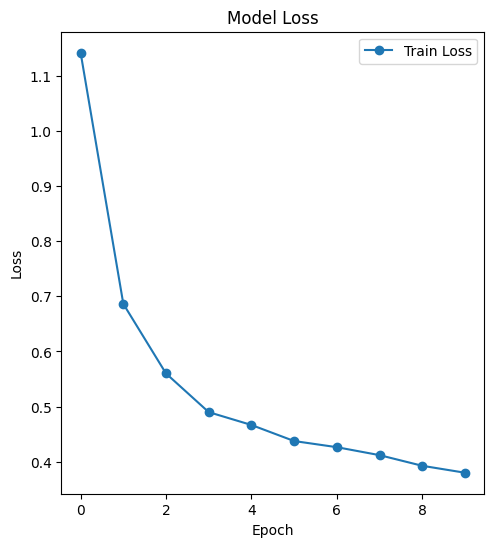

In [ ]:
plt.figure(figsize=(12, 6))

#plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
#plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

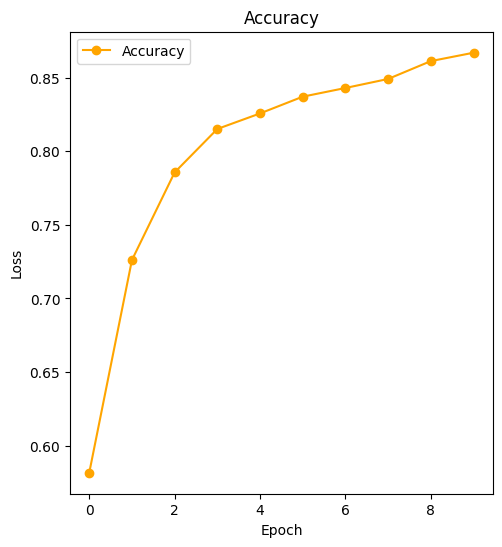

In [ ]:
plt.figure(figsize=(12, 6))

#plot  for  Accuracy over epochs
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy', marker='o',color='orange')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
print(classification_report(y_test_encoded, y_pred_classes, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

    negative       0.77      0.73      0.75      1877
     neutral       0.35      0.59      0.44      1130
    positive       0.94      0.85      0.89      6993

    accuracy                           0.80     10000
   macro avg       0.69      0.72      0.69     10000
weighted avg       0.84      0.80      0.81     10000

